**Advanced Lane Finding Project**


The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Pipe Line

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Images can be radial distorted, this method to remove this distortion  
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Prespective Transform 
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

#The purpose of this function is to transform the image so lane lines can be easily detected. 
#the output of this function is enlaraged road
def perspective_transform(img):

    img_size = (img.shape[1], img.shape[0])

    src = np.float32( [[200, 720],[1100, 720],[595, 450], [685, 450]])
    dst = np.float32([[300, 720],[980, 720],[300, 0],[980, 0]])
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, m_inv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)  # DEBUG

    return warped, unwarped, m, m_inv



# sobelx or sobel y segmantation  
def abs_sobel_thresh(img, orient='x',thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

#this function gives sqrt(sobelx^2+sobely^2)
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# threshould by angle
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

#Threshould by color 
def color_thresh(img,thresh):
    #hue light saturation 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

#combine all the threshould 
def combined_threshoulding(img):
    img = cal_undistort(img, objpoints, imgpoints)
    gradx = abs_sobel_thresh(img, orient='x', thresh=(90, 255))
    grady = abs_sobel_thresh(img, orient='y', thresh=(90, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(55, 150))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0,np.pi/2))
    Color_channel = color_thresh(img, thresh=(90, 255))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (Color_channel == 1)] = 1
    return combined 


#get histogram of the image
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

In C:\Users\ryd-3\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ryd-3\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ryd-3\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\ryd-3\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\ryd-3\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

**Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**

In [3]:
import glob 

images =  glob.glob("camera_cal/calibration*.jpg")

global objpoints,imgpoints 
objpoints,imgpoints = list(),list()
objp = np.zeros((9*6,3),np.float32)
objp[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)

for fname in images: 
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True: 
        imgpoints.append(corners)
        objpoints.append(objp)

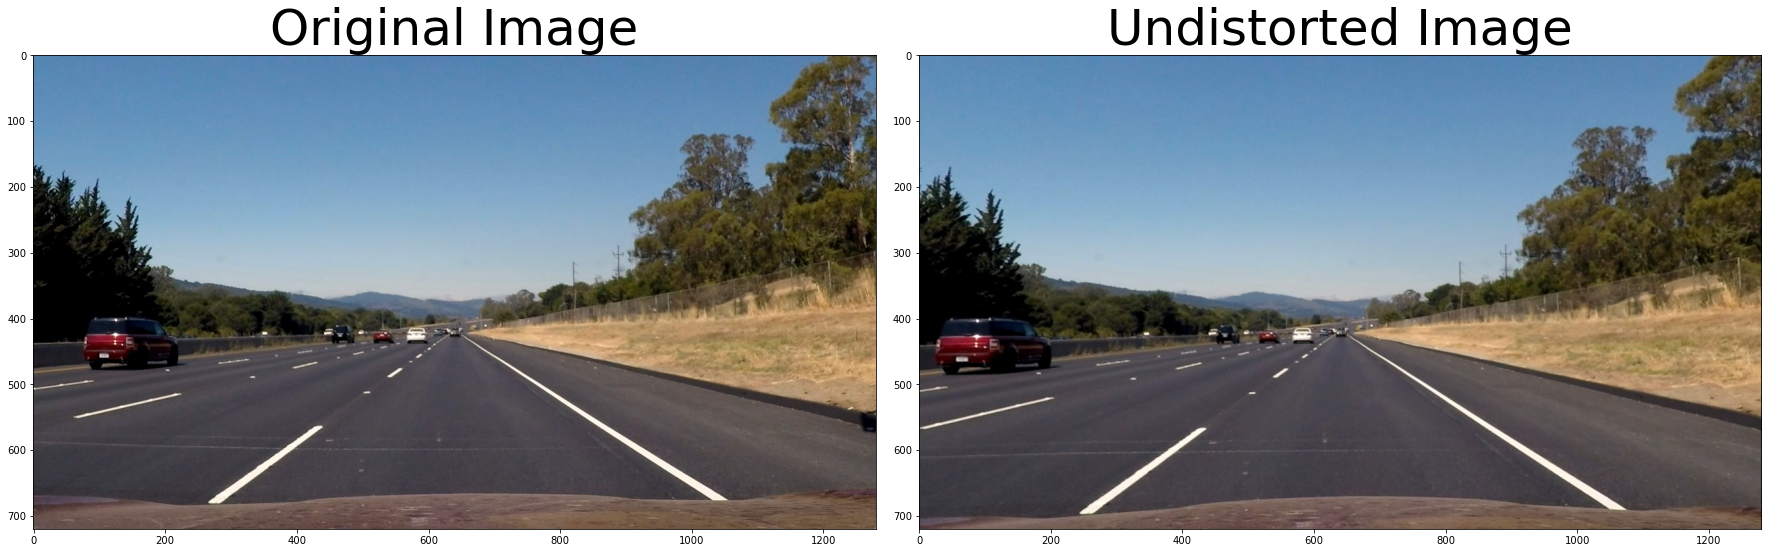

In [9]:
#Apply a distortion correction to raw images.
img = "test_images/straight_lines2.jpg"
img = mpimg.imread(img)
#remove distoration from the image: 
undistorted = cal_undistort(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Use color transforms, gradients, etc., to create a thresholded binary image.**

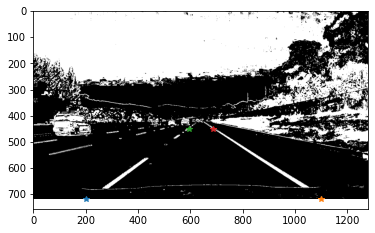

In [10]:
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
#get x sobel (gradient or partial dervative in x direction )
gradx = abs_sobel_thresh(img, orient='x', thresh=(90, 255))
#get y sobel (gradient or partial dervative in y direction )
grady = abs_sobel_thresh(img, orient='y', thresh=(90, 255))
# x and y dervative magnitude 
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(55, 150))
dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0,np.pi/2))
# Color threshoudling 
Color_channel = color_thresh(img, thresh=(90, 255))
combined = np.zeros_like(dir_binary)
#mix them all
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (Color_channel == 1)] = 1
plt.imshow(combined, cmap="gray")
#lane lines points
#my source points
plt.plot(200, 720,"*")
plt.plot(1100, 720,"*")
plt.plot(595, 450,"*")
plt.plot(685, 450,"*")

**Apply a perspective transform to rectify binary image ("birds-eye view") and find histogram**

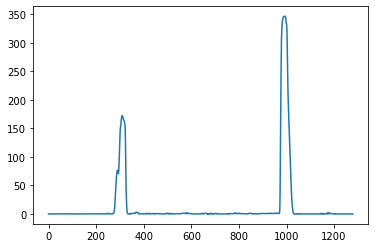

In [34]:
#prespective transform 
warped, unwarped, m, m_inv = perspective_transform(combined)
#histogram to see where lane lines are accumlated
histogram = hist(warped)
plt.plot(histogram)
#plt.imshow(warped, cmap = "gray")


**Detect lane pixels and fit to find the lane boundary, then warp the detected lane boundaries back onto the original image.**

In [35]:
def find_lane_lines(warped_binary_image,histogram):
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    number_of_windows = 9
    #Set height of windows
    window_height = np.int(warped_binary_image.shape[0]/number_of_windows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_pixels = warped_binary_image.nonzero()
    nonzero_y_pixels = np.array(nonzero_pixels[0])
    nonzero_x_pixels = np.array(nonzero_pixels[1])
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
   # Step through the windows one by one
    for window in range(number_of_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin

        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_left_low) & (nonzero_x_pixels < win_x_left_high)).nonzero()[0]
        right_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_right_low) & (nonzero_x_pixels < win_x_right_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x_pixels[left_inds]))
        if len(right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x_pixels[right_inds]))
    
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    left_x = nonzero_x_pixels[left_lane_inds]
    left_y = nonzero_y_pixels[left_lane_inds] 
    right_x = nonzero_x_pixels[right_lane_inds]
    right_y = nonzero_y_pixels[right_lane_inds]
    
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    
    # Get binary warped image size
    image_size = warped_binary_image.shape
    
    # Get max of plot_y
    y_eval = np.max(plot_y)
    
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30/720
    x_m_per_pix = 3.7/700
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*y_m_per_pix, left_x*x_m_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*y_m_per_pix, right_x*x_m_per_pix, 2)
    
    # Calculate radius of curve
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*y_m_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*y_m_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Calculate lane deviation from center of lane
    scene_height = image_size[0] * y_m_per_pix
    scene_width = image_size[1] * x_m_per_pix
    
    # Calculate the intercept points at the bottom of our image
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    center = (left_intercept + right_intercept) / 2.0
    
    # Use intercept points to calculate the lane deviation of the vehicle
    lane_deviation = (center - scene_width / 2.0)
    
    return left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation

In [36]:
def find_lane_pixels(binary_warped,histogram):
    
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    
    # Get binary warped image size
    image_size = binary_warped.shape
    
    # Get max of plot_y
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30/720
    x_m_per_pix = 3.7/700
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*y_m_per_pix, leftx*x_m_per_pix, 2)
    right_fit_cr = np.polyfit(righty*y_m_per_pix, rightx*x_m_per_pix, 2)
    
    # Calculate radius of curve
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*y_m_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*y_m_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Calculate lane deviation from center of lane
    scene_height = image_size[0] * y_m_per_pix
    scene_width = image_size[1] * x_m_per_pix
    
    # Calculate the intercept points at the bottom of our image
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    center = (left_intercept + right_intercept) / 2.0
    
    # Use intercept points to calculate the lane deviation of the vehicle
    lane_deviation = (center - scene_width / 2.0)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curve, right_curve, lane_deviation


**draw rect over the lane**

In [37]:
def draw_lane_lines(warped_binary_image, undistorted_image, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, unwarp, 0.3, 0)
    
    # Write text on image
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2))
    font = cv2.FONT_HERSHEY_TRIPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result


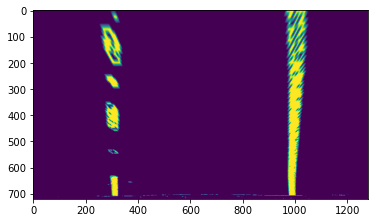

In [40]:
left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation= find_lane_pixels(warped,histogram)
result = draw_lane_lines(warped, undistorted, m_inv, left_fit_x, right_fit_x, plot_y, left_curve, right_curve, lane_deviation)
plt.imshow(warped)

In [16]:
## Test on Videos

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
def process_image(image):
    img = image 
    undistorted = cal_undistort(img, objpoints, imgpoints)
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    #get x sobel (gradient or partial dervative in x direction )
    gradx = abs_sobel_thresh(img, orient='x', thresh=(90, 255))
    #get y sobel (gradient or partial dervative in y direction )
    grady = abs_sobel_thresh(img, orient='y', thresh=(90, 255))
    # x and y dervative magnitude 
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(55, 150))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0,np.pi/2))
    # Color threshoudling 
    Color_channel = color_thresh(img, thresh=(90, 255))
    combined = np.zeros_like(dir_binary)
    #mix them all
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (Color_channel == 1)] = 1
    #prespective transform 
    warped, unwarped, m, m_inv = perspective_transform(combined)
    histogram = hist(warped)
    left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation= find_lane_pixels(warped,histogram)
    result = draw_lane_lines(warped, undistorted, m_inv, left_fit_x, right_fit_x, plot_y, left_curve, right_curve, lane_deviation)
    return result

    

In [32]:
video_output = "output_video/project_video.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_video/project_video.mp4.
Moviepy - Writing video output_video/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_video/project_video.mp4
Wall time: 30min 20s


In [22]:
HTML("""
<video width="540" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))